In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import nan
from topology import get_lognorm_hist, setup_topology
import random
import timeit
import statistics
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from leach import LeachSolver
from mst_prim import prim_mst
from nemo import NemoSolver
import seaborn as sns
import topology
import util
import pandas as pd
from tsp import AnnealingSolver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [4]:
seed = 4
np.random.seed(seed)
avg = 50

X_dim_range = [-500, 500]
Y_dim_range = [-500, 500]
X_dim = [-10, 110]
Y_dim = [-60, 60]

H, bins = get_lognorm_hist()

sigma: [1.41161381] scale: [7.33497171]


In [5]:
# assign nodes to previous clustering alg
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

iterations = 100
slot_col = "capacity_100"
W = 80
L = 100

opt_k = 0
topology_sizes = [100, 1000, 10000, 100000, 500000, 1000000]
no_clusters = [100, 1000, 10000, 100000]
weight_cols = ["weight_1", "weight_2", "weight"]
# topology_sizes = [10000]
weight_cols = ["weight_1"]
c_capacity = 100

In [6]:
def create_topology(tsize, no_cluster):
    device_number = tsize + 1
    max_resources = device_number * avg - 100
    centers = int(max(0.01 * tsize, 10000))

    coords_df = topology.coords_sim(tsize, centers, X_dim_range, Y_dim_range, seed)
    coord_dict = {"sim": coords_df}

    df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                              weights=(1, avg * 2), dist="lognorm",
                                                              with_clustering=False)
    prim_df, c_coords, base_col, slot_columns = df_dict_topologies["sim"]
    prim_df["weight_1"] = 1
    prim_df["weight_2"] = 2

    # clustering
    no_cluster = int(max(2, no_cluster))
    print("Creating topology with size", tsize, "and k", no_cluster)
    prim_df = topology.add_knn_labels(prim_df, no_cluster)

    return prim_df

In [7]:
topologies = []
for tsize in topology_sizes:
    prim_df = create_topology(tsize, tsize * 0.001)
    topologies.append((tsize, prim_df, prim_df[["x", "y"]].to_numpy()))

Creating df for sim
Done
Creating topology with size 100 and k 2
Creating df for sim
Done
Creating topology with size 1000 and k 2
Creating df for sim
Done
Creating topology with size 10000 and k 10
Creating df for sim
Done
Creating topology with size 100000 and k 100
Creating df for sim
Done
Creating topology with size 500000 and k 500
Creating df for sim
Done
Creating topology with size 1000000 and k 1000


In [8]:
df = topologies[len(topologies) - 1][1]
df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,weight_1,weight_2,cluster
0,392.037952,225.805847,0.000000,coordinator,1000002000001,0,100,100,100,100,...,100,100,100,100,100,100,100,1,2,-1
1,-363.753653,-461.578838,1021.625497,worker,1000002000001,2,50,49,49,54,...,52,35,46,46,109,21,49,1,2,545
2,112.403297,235.544926,279.804199,worker,1000002000001,1,50,50,52,58,...,56,38,63,105,41,72,8,1,2,19
3,-234.891715,-403.664179,888.410559,worker,1000002000001,1,50,53,49,44,...,41,57,43,66,52,44,98,1,2,376
4,-51.854254,155.451202,449.433050,worker,1000002000001,1,50,49,56,45,...,44,41,35,81,23,21,94,1,2,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999996,-188.730459,-52.390969,643.960725,worker,1000002000001,19,50,53,51,61,...,39,33,49,32,58,16,38,1,2,374
999997,151.920598,-344.035801,618.365464,worker,1000002000001,1,50,51,53,60,...,69,36,50,76,59,156,12,1,2,429
999998,451.194417,-436.328778,664.771952,worker,1000002000001,1,50,49,51,49,...,36,33,35,30,50,26,0,1,2,707
999999,-126.235862,-389.514055,804.503777,worker,1000002000001,1,50,52,47,52,...,41,58,67,64,24,44,150,1,2,260


In [9]:
df["cluster"].nunique()

1001

## NEMO

In [147]:
nemo_full_dict = {}
nemo_re_dict = {}

# params for NEMO
capacity_col = "capacity_100"
re_opt_rounds = 1

for weight_col in weight_cols:
    nemo_full_weight = []
    nemo_re_weight = []

    for tsize, prim_df, coords in topologies:
        print("Running NEMO", prim_df.shape[0] - 1, ":", weight_col)
        # calc full placement
        nemoSolver = NemoSolver(prim_df, capacity_col, weight_col, max_levels=50, step_size=0.2, merge_factor=0.6)

        start_time = timeit.default_timer()
        df_full, opt_full, limits_full = nemoSolver.nemo_full()
        elapsed = timeit.default_timer() - start_time
        nemo_full_weight.append(elapsed)

        # re-placement
        print("Recalc")
        resource_limits = []
        reopt_levels = []

        nemo_leaf_remove = []
        nemo_parent_remove = []
        nemo_calc_coords = []
        nemo_node_add = []

        for re_run in range(0, re_opt_rounds):
            leaf_nodes = list(set(df_full.index).difference(df_full["parent"].unique()))
            parents = list(df_full["parent"].unique())

            # remove leaf node
            l_idx = leaf_nodes.pop(random.randint(0, len(leaf_nodes) - 1))
            print("removing leaf", l_idx)
            start_time = timeit.default_timer()
            resource_limit1, reopt_level = nemoSolver.remove_nodes([l_idx], return_df=False)
            elapsed = timeit.default_timer() - start_time
            nemo_leaf_remove.append(elapsed)

            # remove parent
            # take a random cluster head to be replaced
            p_idx = parents[random.randint(1, len(parents) - 1)]
            print("removing parent", p_idx)
            start_time = timeit.default_timer()
            resource_limit2, reopt_level = nemoSolver.remove_nodes([p_idx], return_df=False)
            elapsed = timeit.default_timer() - start_time
            nemo_parent_remove.append(elapsed)

            # calc coordinates of a new node
            n_size = 50
            print("calculating new coordinates with k=", n_size)
            neighbours = random.sample(list(df_full["oindex"].unique()), n_size)
            neigh_coords = prim_df.loc[neighbours, ["x", "y"]].to_numpy()
            latencies = np.random.randint(1, 1000, size=n_size)

            start_time = timeit.default_timer()
            n_coords, error = util.get_coords(neigh_coords, latencies)
            elapsed = timeit.default_timer() - start_time
            nemo_calc_coords.append(elapsed)

            # add new node
            new_node = {"x": n_coords[0], "y": n_coords[1], "capacity": prim_df[capacity_col].mean(),
                        "weight": prim_df[weight_col].median()}
            print("adding new node", new_node)
            start_time = timeit.default_timer()
            resource_limit3, reopt_level = nemoSolver.add_nodes([new_node], return_df=False)
            elapsed = timeit.default_timer() - start_time
            nemo_node_add.append(elapsed)

            resource_limits.append(resource_limit1 and resource_limit2 and resource_limit3)
            reopt_levels.append(reopt_level)
            # print("Old node", old_node, "New nodes:", new_cluster_heads, elapsed)

        nemo_re_weight.append(
            {"limit": resource_limits, "level": reopt_levels, "r_leaf": nemo_leaf_remove,
             "r_parent": nemo_parent_remove, "update_coords": nemo_calc_coords, "add_node": nemo_node_add})

    # calc the mean of all runs
    nemo_full_dict[weight_col] = nemo_full_weight
    nemo_re_dict[weight_col] = nemo_re_weight

print("Full runs:", nemo_full_dict)
print("Re-optimization:", nemo_re_dict)

Running NEMO 1000 : weight_1
Level 0 CH number:  1000 Load: 1000
--------Balancing load for 2 clusters to 0
Level 1 CH number:  22 Load: 22
Recalc
removing leaf 672
removing parent 853
Node with ID [853] are cluster head. Re-optimizing children with level 1: {0: [517, 389, 518, 777, 650, 401, 404, 276, 153, 666, 162, 37, 423, 680, 43, 180, 568, 67, 710, 457, 587, 206, 209, 466, 724, 854, 726, 732, 221, 735, 740, 612, 744, 104, 361, 751, 882, 883, 502, 503, 891]}
Level 0 CH number:  41 Load: 41
calculating new coordinates with k= 50
adding new node {'x': 231.87962926884094, 'y': 233.71362346839246, 'capacity': 50.04995004995005, 'weight': 1.0}
re-optimizing clusters dict_keys([1])
Level 0 CH number:  1 Load: 1.0
Running NEMO 10000 : weight_1
Level 0 CH number:  10000 Load: 10000
--------Balancing load for 10 clusters to 0
Level 1 CH number:  212 Load: 212
--------Balancing load for 6 clusters to 0
Level 2 CH number:  6 Load: 6
Recalc
removing leaf 8152
removing parent 3084
Node with ID 

## LEACH

In [49]:
leach_full = []

for tsize, prim_df, coords in topologies:
    print("LEACH run with size", tsize)
    no_centroids = int(tsize * 0.1)

    leachSolver = LeachSolver(prim_df, no_centroids, coords, seed=seed)
    start_time = timeit.default_timer()
    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()
    elapsed = timeit.default_timer() - start_time
    leach_full.append(elapsed)

LEACH run with size 100
LEACH run with size 1000
LEACH run with size 10000
LEACH run with size 100000
LEACH run with size 500000
LEACH run with size 1000000


In [50]:
leach_full

[0.03354996000052779,
 0.3120724059999702,
 3.0932921789999455,
 29.595716148000065,
 146.82815027300057,
 275.6718253019999]

## MST

In [ ]:
mst_full = []

for tsize in topology_sizes:
    print("MST run with size", tsize)
    no_centroids = int(tsize * 0.1)
    device_number = tsize + 1
    max_resources = device_number * avg - 100
    c_capacity = 100
    prim_df, coords, c_coords, slot_columns, sums = setup_topology(H, max_resources, c_capacity, no_centroids,
                                                                   X_dim_range, Y_dim_range, device_number - 1, seed)

    start_time = timeit.default_timer()
    mst = prim_mst(coords)
    elapsed = timeit.default_timer() - start_time
    print("Time with", tsize, ":", elapsed)
    mst_full.append(elapsed)

MST run with size 100
Time with 100 : 0.021984475000863313
MST run with size 1000
Time with 1000 : 1.70713769699978
MST run with size 10000
Time with 10000 : 349.2534674090002
MST run with size 100000


In [ ]:
mst_full

## Chain

In [27]:
chain_full = []

for tsize, prim_df, coords in topologies[:2]:
    print("Starting for ", tsize)
    solver = AnnealingSolver()
    
    start_time = timeit.default_timer()
    route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(coords)
    elapsed = timeit.default_timer() - start_time
    print("Time with", tsize, ":", elapsed)
    chain_full.append(elapsed)

Starting for  100
i:0, t(i):10.00, valueNow:41685.0, valueBest:41685.0
i:10, t(i):9.04, valueNow:24119.0, valueBest:24119.0
i:20, t(i):8.18, valueNow:21440.0, valueBest:21440.0
i:30, t(i):7.40, valueNow:20401.0, valueBest:20401.0
i:40, t(i):6.69, valueNow:19200.0, valueBest:19200.0
i:50, t(i):6.05, valueNow:18300.0, valueBest:18300.0
i:60, t(i):5.47, valueNow:17327.0, valueBest:17327.0
i:70, t(i):4.95, valueNow:17044.0, valueBest:17044.0
i:80, t(i):4.48, valueNow:16590.0, valueBest:16590.0
i:90, t(i):4.05, valueNow:16047.0, valueBest:16047.0
i:100, t(i):3.66, valueNow:15848.0, valueBest:15848.0
i:110, t(i):3.31, valueNow:15440.0, valueBest:15440.0
i:120, t(i):2.99, valueNow:15280.0, valueBest:15280.0
i:130, t(i):2.71, valueNow:15063.0, valueBest:15058.0
i:140, t(i):2.45, valueNow:15050.0, valueBest:15050.0
i:150, t(i):2.21, valueNow:14929.0, valueBest:14929.0
i:160, t(i):2.00, valueNow:14884.0, valueBest:14884.0
i:170, t(i):1.81, valueNow:14621.0, valueBest:14621.0
i:180, t(i):1.64, va

In [28]:
chain_full

[2.4442093559991918, 202.41057145599916]

## Plotting Results

In [34]:
full_opt_nemo = [0.1079521339997882, 0.622427074999905, 5.664643757999784, 59.286709083000005, 269.86223116500014,
                 570.7745339570006]

re_opt_nemo = [0, 0.007547808000708756, 0.006926729250153585, 0.023670921999837446, 0.10586756825068733, 0.23290501625069737]

full_opt_nemo_w40 = {
    'weight_1': [0.020192094000776706, 0.33320871599971724, 2.1779831339999873, 19.59997446899979, 108.33851838900046,
                 224.6158432759994],
    'weight_2': [0.07559815599961439, 0.3937772320005024, 2.067196232999777, 20.257177860999946, 103.98976772700007,
                 250.16779670899996],
    'weight': [0.1485775150003974, 0.57200767500035, 2.8169211710001036, 25.86398674300017, 136.0401925619999,
               294.3114099689992]}

full_opt_nemo_w200 = {
    'weight_1': [0.01819458499812754, 0.5680287890027103, 4.703705074000027, 41.52002448699932, 229.28963692499747,
                 481.0292443159997],
    'weight_2': [0.05660125699796481, 0.7645569489977788, 5.0126434809972125, 44.16308923299948, 238.38165584300077,
                 515.8344902279969],
    'weight': [0.14514595700165955, 1.278073833000235, 6.426279245999467, 54.08242802600216, 286.8650176439987,
               642.1444632769999]}

opt_leach = [0.03354996000052779, 0.3120724059999702, 3.0932921789999455, 29.595716148000065, 146.82815027300057,
             275.6718253019999]

opt_mst = [0.021984475000863313, 1.70713769699978, 349.2534674090002, np.nan, np.nan, np.nan]

opt_chain = [0, 2.44, 202,  np.nan, np.nan, np.nan]

opt_card = [975, np.nan, np.nan, np.nan, np.nan, np.nan]

approaches = {
    "nemo": full_opt_nemo,
    "nemo+": full_opt_nemo_w200,
    "nemo re-optimization": re_opt_nemo,
    "leach": opt_leach,
    "mst": opt_mst,
    "chain": opt_chain,
    "optimal": opt_card
}

color_list = sns.color_palette(n_colors=17)
colors = np.asarray(color_list.as_hex())
colors = {
    "nemo": "pink",
    "nemo re-optimization": "magenta",
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "optimal": "blue",
    "weight_1": colors[6],
    "weight_2": colors[7],
    "weight": colors[8],
    "nemo+, w=1": colors[6],
    "nemo+, w=2": colors[7],
    "nemo+, w=ln(1,50)": colors[8]
}

styles = {
    "nemo": "--",
    "nemo+": "--",
    "nemo re-optimization": "-",
    "leach": "-",
    "mst": "--",
    "chain": "..",
    "optimal": ":"
}

markers = {
    "nemo": "s",
    "nemo+": "D",
    "nemo re-optimization": "1",
    "leach": "d",
    "mst": "^",
    "chain": "<",
    "optimal": "x"
}

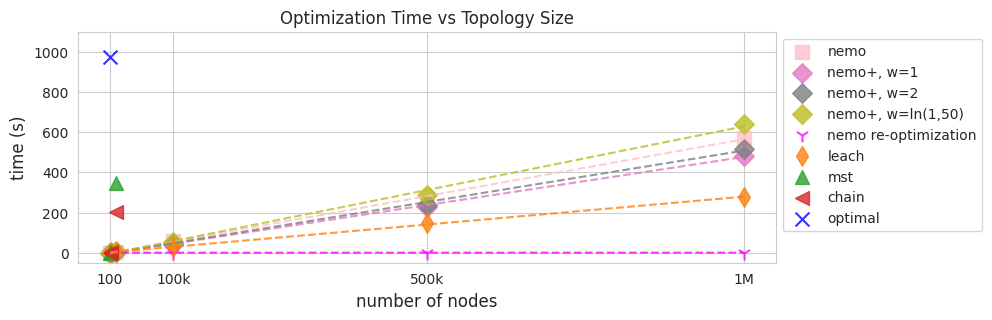

In [36]:
fig, ax = plt.subplots(figsize=(9, 3))

for k, v in approaches.items():
    if k == "nemo+":
        for weight, v in v.items():
            if weight == "weight":
                wl = ", w=ln(1,50)"
            else:
                wl = weight.replace("weight_", ", w=")
            ax.scatter(topology_sizes, v, label=k + wl, s=100, alpha=0.8, marker=markers[k], color=colors[weight])

            # calculate the linear regression line
            slope, intercept = np.polyfit(topology_sizes, v, 1)
            full_opt_line = np.poly1d((slope, intercept))(np.array(topology_sizes))
            # plot the linear regression line
            ax.plot(topology_sizes, full_opt_line, "--", alpha=0.8, color=colors[weight])
    else:
        # create a scatter plot
        ax.scatter(topology_sizes, v, label=k, s=100, alpha=0.8, marker=markers[k], color=colors[k])

        # calculate the linear regression line
        slope, intercept = np.polyfit(topology_sizes, v, 1)
        full_opt_line = np.poly1d((slope, intercept))(np.array(topology_sizes))
        # plot the linear regression line
        ax.plot(topology_sizes, full_opt_line, "--", alpha=0.8, color=colors[k], linewidth=1.5)

# set the axis labels and title
ax.set_xlabel('number of nodes', fontsize=12)
ax.set_ylabel('time (s)', fontsize=12)

# Set the legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.ticklabel_format(style='plain', axis='x')

# Set the x-ticks and format the tick labels
xticks = [100, 100000, 500000, 1000000]
xtick_labels = [f"{xtick // 1000}k" if xtick < 1000000 else f"{xtick // 1000000}M" for xtick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Set the tick label format for the x-axis
formatter = FuncFormatter(lambda x, pos: f"{x}" if x < 1000 else f"{x // 1000}k" if x < 1000000 else f"{x // 1000000}M")
ax.xaxis.set_major_formatter(formatter)

ax.set_ylim([-50, 1100])

plt.savefig("plots/scalability.svg", bbox_inches="tight")

# show the plot
plt.title('Optimization Time vs Topology Size')
plt.show()

### Re-optimization

In [259]:
re_opt_nemo = [0.0025799939999160415, 0.0016037149998737732, 0.0018865340002776065, 0.0028179860000818735,
               0.006405561000065063, 0.014996855000390497]

re_opt_nemo_w40 = {'weight_1': [{'runtimes': [0], 'limit': [False], 'level': [nan]}, {
    'runtimes': [0.0020533220003926544, 0.005811578999782796, 0.0045612149997396045, 0.008215360000576766,
                 0.007425742999657814, 0.011412981000830769, 0.008761697999943863, 0.008260110999799508,
                 0.00477040100031445], 'limit': [False, False, False, False, False, False, False, False, False],
    'level': [nan, nan, nan, nan, nan, 0, 0, 0, 0]}, {
                                    'runtimes': [0.014804200000071432, 0.0007559320001746528, 0.014014358999702381,
                                                 0.0008848769994074246, 0.013598715999250999, 0.0021398999997472856,
                                                 0.013800522000565252, 0.01440567400004511, 0.00275573799990525],
                                    'limit': [False, False, False, False, False, False, False, False, False],
                                    'level': [nan, nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                    'runtimes': [1.3771528019997277, 2.4154914790005932, 0.006539125999552198,
                                                 0.06043131699971127, 0.0070821200006321305, 0.007009532999290968,
                                                 0.007203856000160158, 0.0651488090006751, 0.061297206000745064,
                                                 0.06009947300026397],
                                    'limit': [False, False, False, False, False, False, False, False, False, False],
                                    'level': [2, 1, nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                    'runtimes': [8.479498798999884, 19.420335763000367, 0.006952278000426304,
                                                 0.006825093999395904, 0.006804897999245441, 0.00686221999967529,
                                                 0.006851203999758582, 0.0067856639998353785, 0.006765238000298268,
                                                 0.00729959299951588],
                                    'limit': [False, False, False, False, False, False, False, False, False, False],
                                    'level': [2, 1, nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                    'runtimes': [17.89843898899926, 17.946490637000352, 17.78389663100006,
                                                 18.101884261000123, 17.968753212999218, 17.724193469000056,
                                                 17.73931854700004, 17.98686228599945, 18.09009763999984,
                                                 18.036819576000198],
                                    'limit': [False, False, False, False, False, False, False, False, False, False],
                                    'level': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}], 'weight_2': [{'runtimes': [
    0.0006143949995021103, 0.0010147670000151265, 0.0021000220003770664, 0.0025777349992495147, 0.0030572449995815987],
    'limit': [False, False,
              False, False,
              False],
    'level': [nan, nan, nan,
              nan, nan]}, {
    'runtimes': [
        0.0025595429997338215,
        0.0063072389993976685,
        0.14817289199982042,
        0.005691885000487673,
        0.006025270999998611,
        0.006133262999355793,
        0.0005899779998799204,
        0.0034244100006617373,
        0.0007127399994715233],
    'limit': [False, False,
              False, False,
              False, False,
              False, False,
              False],
    'level': [nan, nan, 1,
              nan, nan, nan,
              nan, nan,
              nan]}, {
    'runtimes': [
        0.010008084000219242,
        0.00957683900014672,
        0.1827797930000088,
        0.010202242000559636,
        0.011435895999966306,
        0.011138001999825065,
        0.009906084000249393,
        0.001940303999617754,
        0.009812050999244093,
        0.028552378000313183],
    'limit': [False, False,
              False, False,
              False, False,
              False, False,
              False, False],
    'level': [nan, nan, 2,
              nan, nan, nan,
              nan, nan, nan,
              2]}, {
    'runtimes': [
        1.517874410999866,
        1.9330986400000256,
        1.671226552999542,
        1.9835062439997273,
        4.102402087000883,
        0.003575447000002896,
        0.0035089359998892178,
        0.0030434219997914624,
        0.05617116699977487,
        0.0035430520001682453],
    'limit': [False, False,
              False, False,
              False, False,
              False, False,
              False, False],
    'level': [2, 2, 2, 2, 1,
              nan, nan, nan,
              nan, nan]}, {
    'runtimes': [
        17.232414207999682,
        26.848496189000798,
        0.004079422999893723,
        0.003650917999948433,
        0.003673347000585636,
        0.0031684750001659268,
        0.0033718249997036764,
        0.0024198520004574675,
        0.0036837999996350845,
        0.003690457999255159],
    'limit': [False, False,
              False, False,
              False, False,
              False, False,
              False, False],
    'level': [2, 1, nan,
              nan, nan, nan,
              nan, nan, nan,
              nan]}, {
    'runtimes': [
        59.28959833600038,
        0.004591437000271981,
        0.003899753000041528,
        0.003820441999778268,
        0.0039547410005980055,
        0.003868851999868639,
        0.003866080000079819,
        0.003466140999989875,
        0.004143614999520651,
        0.0034495509999032947],
    'limit': [False, False,
              False, False,
              False, False,
              False, False,
              False, False],
    'level': [1, nan, nan,
              nan, nan, nan,
              nan, nan, nan,
              nan]}],
                   'weight': [{'runtimes': [0.0034194380004919367, 0.0007435070001520216, 0.003117303000180982,
                                            0.0007436400001097354, 0.001142875999903481, 0.003096262000326533,
                                            0.000656845999401412, 0.0017625369991947082],
                               'limit': [False, False, False, False, False, False, False, False],
                               'level': [nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                  'runtimes': [0.003100464999988617, 0.0031239179998010513, 0.056841480000002775,
                                               0.0004925319999529165, 0.0006075669998608646, 0.003483069000139949,
                                               0.004727690999970946, 0.006960224000067683, 0.006233340000108001,
                                               0.43240583799979504],
                                  'limit': [False, False, False, False, False, False, False, False, False, False],
                                  'level': [nan, nan, 3, nan, nan, nan, nan, nan, nan, 1]}, {
                                  'runtimes': [1.138492959999894, 0.6321813220001786, 0.007314966999729222,
                                               0.001793944999917585, 0.007452674999512965, 0.007658900000024005,
                                               0.006322485000055167, 0.007848836999983178, 0.008470609000141849,
                                               0.0015969050000421703],
                                  'limit': [False, False, False, False, False, False, False, False, False, False],
                                  'level': [1, 2, nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                  'runtimes': [8.021875452000131, 0.051320786000360386, 0.05439285499960533,
                                               0.05081055299979198, 0.051030200000241166, 0.0015565800003969343,
                                               0.051096883000354865, 0.05056724799942458, 0.0011093350003648084,
                                               0.0521520310003325],
                                  'limit': [False, False, False, False, False, False, False, False, False, False],
                                  'level': [1, nan, nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                  'runtimes': [14.22999209200043, 15.009259663999728, 11.32381976600027,
                                               21.885265126000377, 23.552047262000087, 16.038474905999465,
                                               21.813319451000098, 23.54733513100018, 22.947342745999777,
                                               23.39003099099955],
                                  'limit': [False, False, False, False, False, False, False, False, False, False],
                                  'level': [3, 3, 4, 2, 2, 3, 2, 2, 2, 2]}, {
                                  'runtimes': [31.066093121999984, 91.43132835199958, 0.5542742749994432,
                                               0.001215039000271645, 0.5411532480002279, 0.5456048259993622,
                                               0.5389938759999495, 0.5424066139994466, 0.534926147999613,
                                               0.5393338190006034],
                                  'limit': [False, False, False, False, False, False, False, False, False, False],
                                  'level': [3, 1, nan, nan, nan, nan, nan, nan, nan, nan]}]}

re_opt_nemo_w200 = {'weight_1': [{'runtimes': [0], 'limit': [False], 'level': [nan]}, {
    'runtimes': [0.004602054999850225, 0.004889421001280425, 0.004126121999433963, 0.00393670999983442,
                 0.004219611000735313, 0.004618061000655871, 0.005815168002300197, 0.004966872002114542,
                 0.005458330997498706], 'limit': [False, False, False, False, False, False, False, False, False],
    'level': [nan, nan, nan, nan, nan, nan, 0, 0, 0]}, {
                                     'runtimes': [0.0009704149997560307, 0.005140358000062406, 0.015369124001153978,
                                                  0.006627000999287702, 0.015768558001582278, 0.0007022970021353103,
                                                  0.006716720999975223, 0.017183473999466514, 0.003634421998867765,
                                                  0.0008299399996758439],
                                     'limit': [False, False, False, False, False, False, False, False, False, False],
                                     'level': [nan, nan, nan, nan, 0, nan, nan, 0, nan, nan]}, {
                                     'runtimes': [0.06207136000011815, 0.06527665500107105, 0.06484154999998282,
                                                  0.06772135799837997, 0.004201703999569872, 0.06276326799707022,
                                                  0.0625343219981005, 0.06470439500117209, 0.06226569000136806,
                                                  0.06398838800305384],
                                     'limit': [False, False, False, False, False, False, False, False, False, False],
                                     'level': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                     'runtimes': [114.80496835200029, 0.31802644900017185, 0.006803059997764649,
                                                  0.006859633002022747, 0.006798520000302233, 0.006779376999475062,
                                                  0.006740234999597305, 0.006672922001598636, 0.29506257200046093,
                                                  0.00661008099996252],
                                     'limit': [False, False, False, False, False, False, False, False, False, False],
                                     'level': [1, nan, nan, nan, nan, nan, nan, nan, nan, nan]}, {
                                     'runtimes': [263.1537965360003, 0.007164804999774788, 0.006541440001456067,
                                                  0.006699040997773409, 0.6775283520000812, 0.0007873319991631433,
                                                  0.6728383020017645, 0.006659229002252687, 0.006533648000186076,
                                                  0.006541253998875618],
                                     'limit': [False, False, False, False, False, False, False, False, False, False],
                                     'level': [1, nan, nan, nan, nan, nan, nan, nan, nan, nan]}], 'weight_2': [{
    'runtimes': [
        0.0006969150017539505,
        0.0013246970011095982,
        0.0021826379997946788,
        0.001580290001584217,
        0.003904311000951566,
        0.0037508940004045144],
    'limit': [
        False,
        False,
        False,
        False,
        False,
        False],
    'level': [
        nan,
        nan,
        nan,
        nan,
        nan,
        nan]},
    {
        'runtimes': [
            0.0012100690000806935,
            0.0008420459998887964,
            0.006249099998967722,
            0.0054845790000399575,
            0.004652194998925552,
            0.0067562820004241075,
            0.004572581001411891,
            0.0005825549997098278,
            0.0006996240008447785],
        'limit': [
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False],
        'level': [
            nan,
            nan,
            0,
            0,
            0,
            0,
            0,
            nan,
            nan]},
    {
        'runtimes': [
            0.010950703999696998,
            0.009748340002261102,
            0.0005836539967276622,
            0.0016833839981700294,
            0.002660313002706971,
            0.0016796149975562003,
            0.009633648998715216,
            0.0005812730014440604,
            0.009262847997888457,
            0.009365414000058081],
        'limit': [
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False],
        'level': [
            nan,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan]},
    {
        'runtimes': [
            20.620782553000026,
            0.05647405000127037,
            0.05592872900160728,
            0.0006313029989541974,
            0.05737111900089076,
            0.0030438149988185614,
            0.003524613999616122,
            0.057684577001055004,
            0.003521473001455888,
            0.0008902760018827394],
        'limit': [
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False],
        'level': [
            1,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan,
            nan]},
    {
        'runtimes': [
            0.5799515590006195,
            66.4907915679978,
            0.2917770489984832,
            63.721506837999186,
            69.60928525300187,
            0.29603154900178197,
            67.27412198599995,
            0.5778202069996041,
            122.50959337399763,
            0.004270953002560418],
        'limit': [
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False],
        'level': [
            nan,
            2,
            nan,
            2,
            2,
            nan,
            2,
            nan,
            1,
            nan]},
    {
        'runtimes': [
            152.69866355900012,
            144.92120935800267,
            151.13055739999982,
            153.50881242700052,
            160.18116887799988,
            160.38809605300048,
            290.9359346889978,
            0.00409536499864771,
            0.0036734000022988766,
            0.6716045620014484],
        'limit': [
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False,
            False],
        'level': [
            2,
            2,
            2,
            2,
            2,
            2,
            1,
            nan,
            nan,
            nan]}],
                    'weight': [{'runtimes': [0.03413060199818574, 0.003521017999446485, 0.08628842599864583,
                                             0.0015045030013425276], 'limit': [False, False, False, False],
                                'level': [2, nan, 1, nan]}, {
                                   'runtimes': [0.004108231001737295, 0.1844642500000191, 0.0010154370029340498,
                                                0.004713180001999717, 0.0037748350005131215, 0.0019324080021760892,
                                                0.0014802959994995035, 0.0034495899999456014, 0.00833855000018957,
                                                0.0006379570004355628],
                                   'limit': [False, False, False, False, False, False, False, False, False, False],
                                   'level': [nan, 2, nan, nan, nan, nan, nan, nan, 0, nan]}, {
                                   'runtimes': [0.00636761799978558, 0.5514390230018762, 1.7539636399997107,
                                                1.282393282999692, 0.007036398998025106, 0.006411974001821363,
                                                3.4010848739999346, 0.0012079730004188605, 0.000612781001109397,
                                                0.011481374996947125],
                                   'limit': [False, False, False, False, False, False, False, False, False, False],
                                   'level': [nan, 3, 2, 2, nan, nan, 1, nan, nan, nan]}, {
                                   'runtimes': [17.217783309999504, 16.98056606799946, 10.723028621003323,
                                                17.692616401000123, 12.0066810740027, 0.05745476700030849,
                                                17.137885980999272, 17.39104033500189, 17.398676565000642,
                                                13.160525856001186],
                                   'limit': [False, False, False, False, False, False, False, False, False, False],
                                   'level': [2, 2, 3, 2, 3, nan, 2, 2, 2, 3]}, {
                                   'runtimes': [98.36000250800134, 99.86005990799822, 46.14665072099888,
                                                73.84669217600094, 109.16819850500178, 80.23220764000143,
                                                152.4905640850011, 0.2727634629991371, 0.25734265800201683,
                                                0.7621709280028881],
                                   'limit': [False, False, False, False, False, False, False, False, False, False],
                                   'level': [2, 2, 4, 3, 2, 3, 1, nan, nan, nan]}, {
                                   'runtimes': [224.9105821580015, 163.53683656800058, 0.5890322310006013,
                                                0.568068388998654, 0.5643973519981955, 228.41483569200136,
                                                242.03345208300016, 236.47079359100098, 351.928518282999,
                                                0.5888253129996883],
                                   'limit': [False, False, False, False, False, False, False, False, False, False],
                                   'level': [2, 3, nan, nan, nan, 2, 2, 2, 1, nan]}]}

re_approaches = {
    "nemo": re_opt_nemo,
    # "nemo+": full_opt_nemo_w,
}

In [302]:
import pandas as pd

# Unnest the nested dictionary
df_data = []

# plot nemo+
for weight_key, weight_list in re_opt_nemo_w200.items():
    i = 0
    for item in weight_list:
        size = topology_sizes[i]
        for round in range(0, len(item["runtimes"])):
            if weight_key == "weight":
                weight_key = "nemo+, w=ln(1,50)"
            elif weight_key == "weight_1":
                weight_key = "nemo+, w=1"
            elif weight_key == "weight_2":
                weight_key = "nemo+, w=2"
            row = {'weight_key': weight_key, 'size': size, "runtime": item["runtimes"][round],
                   "limit": item["limit"][round], "level": item["level"][round]}
            df_data.append(row)
        i += 1

# Create DataFrame
df = pd.DataFrame(df_data)
df = df.fillna(df["level"].max())
df["level"] = df["level"].astype(int)
# df = df[df["level"] <= 3]
df["level"] = df["level"].max() - df["level"]
# df["level"] = df["level"].astype('int')
# df = df[df["level"] > 0]
df

,weight_key,size,runtime,limit,level
0,"nemo+, w=1",100,0.000000,False,0
1,"nemo+, w=1",1000,0.004602,False,0
2,"nemo+, w=1",1000,0.004889,False,0
3,"nemo+, w=1",1000,0.004126,False,0
4,"nemo+, w=1",1000,0.003937,False,0
...,...,...,...,...,...
154,"nemo+, w=ln(1,50)",1000000,228.414836,False,2
155,"nemo+, w=ln(1,50)",1000000,242.033452,False,2
156,"nemo+, w=ln(1,50)",1000000,236.470794,False,2
157,"nemo+, w=ln(1,50)",1000000,351.928518,False,3


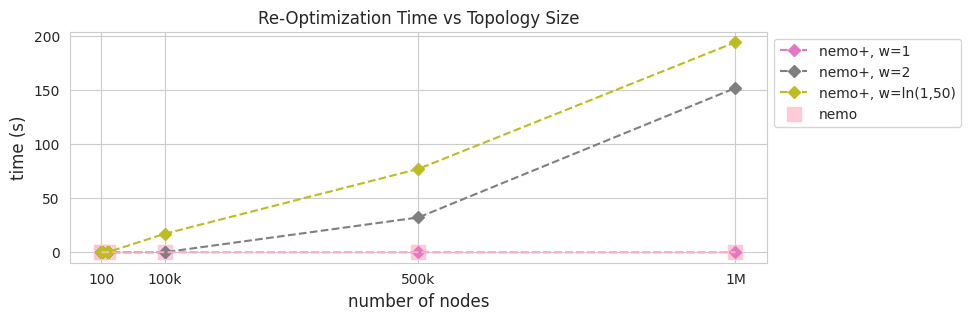

In [306]:
fig, ax = plt.subplots(figsize=(9, 3))

# Group by 'column1' and 'column2', calculate mean of 'value'
c1 = "weight_key"
c2 = "size"
grouped_df = df.groupby([c1, c2])["runtime"].median().reset_index()

# plot nemo+
for name, group in grouped_df.groupby(c1):
    ax.plot(group[c2], group['runtime'], styles["nemo+"], marker=markers["nemo+"], label=name, color=colors[name])

# plot vanilla nemo
ax.scatter(topology_sizes, re_opt_nemo, label="nemo", s=100, alpha=0.8, marker=markers["nemo"], color=colors["nemo"])

# calculate the linear regression line
slope, intercept = np.polyfit(topology_sizes, re_opt_nemo, 1)
full_opt_line = np.poly1d((slope, intercept))(np.array(topology_sizes))
# plot the linear regression line
ax.plot(topology_sizes, full_opt_line, "--", alpha=0.8, color=colors["nemo"])

# set the axis labels and title
ax.set_xlabel('number of nodes', fontsize=12)
ax.set_ylabel('time (s)', fontsize=12)

# Set the legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.ticklabel_format(style='plain', axis='x')

# Set the x-ticks and format the tick labels
xticks = [100, 100000, 500000, 1000000]
xtick_labels = [f"{xtick // 1000}k" if xtick < 1000000 else f"{xtick // 1000000}M" for xtick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Set the tick label format for the x-axis
formatter = FuncFormatter(lambda x, pos: f"{x}" if x < 1000 else f"{x // 1000}k" if x < 1000000 else f"{x // 1000000}M")
ax.xaxis.set_major_formatter(formatter)

plt.savefig("plots/re-optimization.svg", bbox_inches="tight")

# show the plot
plt.title('Re-Optimization Time vs Topology Size')
plt.show()

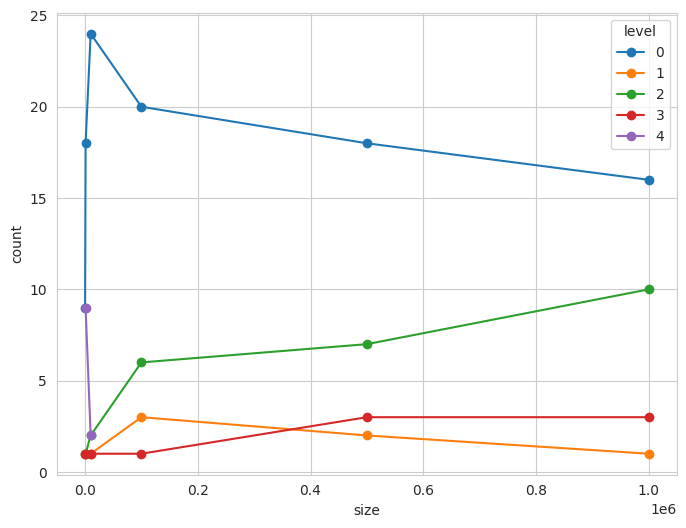

In [307]:
# Group by 'column1' and 'column2', calculate mean of 'value'
c1 = "level"
c2 = "size"
grouped_df = df.groupby([c2, c1])[c1].size().reset_index(name="count")
# Plot the grouped data
plt.figure(figsize=(8, 6))

for name, group in grouped_df.groupby(c1):
    plt.plot(group[c2], group['count'], marker='o', label=name)

plt.xlabel(c2)
plt.ylabel('count')

plt.legend(title="level")
plt.show()

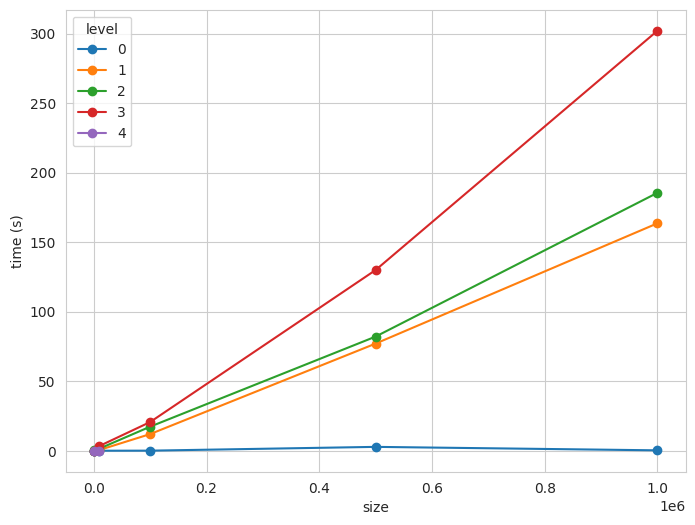

In [308]:
# Group by 'column1' and 'column2', calculate mean of 'value'
c1 = "level"
c2 = "size"
grouped_df = df.groupby([c1, c2])["runtime"].mean().reset_index()

# Plot the grouped data
plt.figure(figsize=(8, 6))

for name, group in grouped_df.groupby(c1):
    plt.plot(group[c2], group['runtime'], marker='o', label=name)

plt.xlabel(c2)
plt.ylabel('time (s)')

plt.legend(title="level")
plt.show()

In [149]:
nemo_p_full = {'weight_1': [0.20093900199935888, 2.0744600770012767, 28.539408381999237, 392.74592308499996, 1548.1728387570001]}

nemo_p_re = {'weight_1': [{'limit': [False], 'level': [0], 'r_leaf': [0.001715997001156211], 'r_parent': [0.011603803999605589], 'update_coords': [0.013330339999811258], 'add_node': [0.0035410910022619646]}, {'limit': [False], 'level': [0], 'r_leaf': [0.0023899709995021112], 'r_parent': [0.011396881000109715], 'update_coords': [0.010406904999399558], 'add_node': [0.003513160001602955]}, {'limit': [False], 'level': [0], 'r_leaf': [0.010570017999270931], 'r_parent': [0.06956450399957248], 'update_coords': [0.0055892060008773115], 'add_node': [0.008959959999629064]}, {'limit': [False], 'level': [0], 'r_leaf': [0.04732397900079377], 'r_parent': [0.3324728139996296], 'update_coords': [0.009437832999537932], 'add_node': [0.03423564700278803]}, {'limit': [False], 'level': [0], 'r_leaf': [0.10050751900053001], 'r_parent': [0.7550059260029229], 'update_coords': [0.011317852997308364], 'add_node': [0.06478876700202818]}]}

In [150]:
nemo_p_re["weight_1"][0]["r_leaf"]

[0.001715997001156211]

In [151]:
topology_sizes

[1000, 10000, 100000, 500000, 1000000]

Re-optimizations: [0.007547808000708756, 0.006926729250153585, 0.023670921999837446, 0.10586756825068733, 0.23290501625069737]


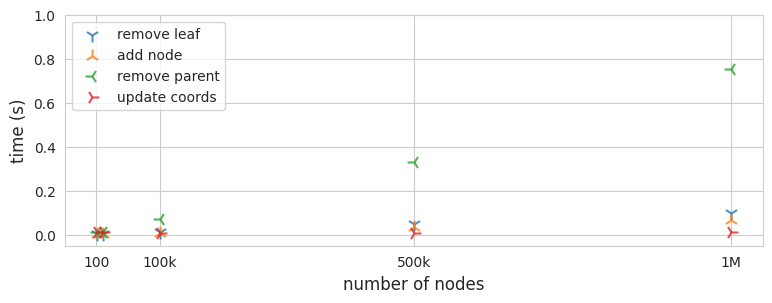

In [164]:
fig, ax = plt.subplots(figsize=(9, 3))
re_optimizations = []

for weight in nemo_p_re.keys():
    r_leafs = []
    add_nodes = []
    r_parents = []
    calc_coords = []
    for i in range(len(topology_sizes)):
        r_leafs.append(np.mean(nemo_p_re[weight][i]["r_leaf"]))
        add_nodes.append(np.mean(nemo_p_re[weight][i]["add_node"]))
        r_parents.append(np.mean(nemo_p_re[weight][i]["r_parent"]))
        calc_coords.append(np.mean(nemo_p_re[weight][i]["update_coords"]))
    re_optimizations = np.array([r_leafs, add_nodes, r_parents, calc_coords])
    re_optimizations = np.mean(re_optimizations, axis=0)
    print("Re-optimizations:", list(re_optimizations))
    
    ax.scatter(topology_sizes, r_leafs, label="remove leaf", s=100, alpha=0.8, marker="1")
    ax.scatter(topology_sizes, add_nodes, label="add node", s=100, alpha=0.8, marker="2")
    ax.scatter(topology_sizes, r_parents, label="remove parent", s=100, alpha=0.8, marker="3")
    ax.scatter(topology_sizes, calc_coords, label="update coords", s=100, alpha=0.8, marker="4")


# set the axis labels and title
ax.set_xlabel('number of nodes', fontsize=12)
ax.set_ylabel('time (s)', fontsize=12)

# Set the legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.ticklabel_format(style='plain', axis='x')

# Set the x-ticks and format the tick labels
xticks = [100, 100000, 500000, 1000000]
xtick_labels = [f"{xtick // 1000}k" if xtick < 1000000 else f"{xtick // 1000000}M" for xtick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Set the tick label format for the x-axis
formatter = FuncFormatter(lambda x, pos: f"{x}" if x < 1000 else f"{x // 1000}k" if x < 1000000 else f"{x // 1000000}M")
ax.xaxis.set_major_formatter(formatter)

ax.set_ylim([-0.05, 1])
ax.legend()

plt.savefig("plots/nemo_re-optimization.svg", bbox_inches="tight")
plt.show()